Dataset reference : ARIMA&Prophet_data.csv

In [1]:
# Loading the required Python libraries

import warnings 
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pylab import rcParams
import itertools
from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# Importing the dataset as pandas data frame
sales_df = pd.read_csv('Store85 Sales.csv')
print('The sample of the dataframe is shown below and the dataframe has the following dimensions : ', sales_df.shape)
sales_df.head(5)

The sample of the dataframe is shown below and the dataframe has the following dimensions :  (942, 2)


,Date,Sales
0,1/1/2013,4220
1,1/2/2013,6069
2,1/3/2013,5246
3,1/4/2013,5339
4,1/5/2013,5774


In [3]:
# Changing the index of the datarame to Date
sales_df = sales_df.set_index('Date')
sales_df.head()

,Sales
Date,
1/1/2013,4220
1/2/2013,6069
1/3/2013,5246
1/4/2013,5339
1/5/2013,5774


The time series plot of the data :


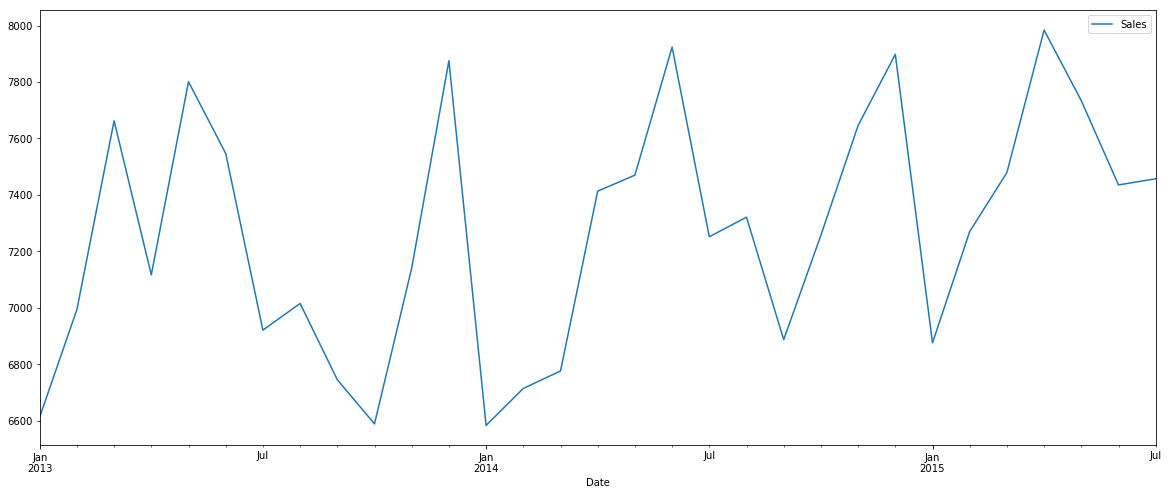

In [4]:
print("The time series plot of the data :")
sales_df.index = pd.to_datetime(sales_df.index)
sales_df.resample('MS').mean().plot(figsize = (20,8))
plt.show()

From the above plot, we observe some distinguishable patterns - like seasonality pattern.

That is, the sales are always low at the beginning of the year, tend to have a peak just before the year end's sales drop. Also, there is an upward trend within any single year around the mid of the year.

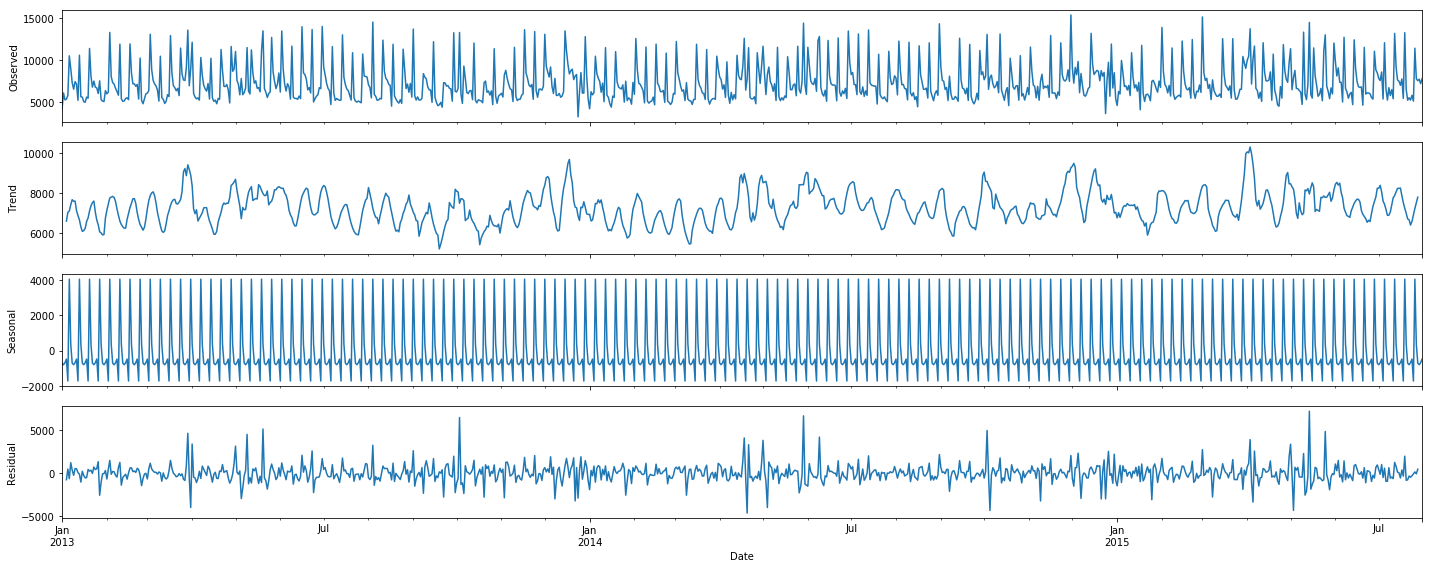

In [5]:
# Visualizing the data - using Time Series decomposition
# Allows to decompose the data into 3 distinct components - Trend, Seasonality, Noise

rcParams['figure.figsize'] = 20,8

decomposition = sm.tsa.seasonal_decompose(sales_df, model = 'additive')
fig = decomposition.plot()
plt.show()

From the above decomposition plot, we can see our time series does not show any clear trend. However, we can observe seasonality pattern and residual variance show same pattern around the mid point of Jan and July every year.

Before proceeding further, the time series need to be made stationary i.e., it should exhibit constant statistical properties of mean, variance, auto correlation etc. For example, the mean of the time series should not increase over time. Some of the popular transforms used to make data stationary are:

a) De-trending
b) Differencing
c) Logging


Fitting an ARIMA model requires the series to be stationary. A series is said to be stationary when its mean, variance, and autocovariance are time invariant.

The augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected. 

In [6]:
# Checking Stationarity

print('Results of Dickey - Fuller (ADF) test : Is the data stationary ?')

dftest = adfuller(sales_df.Sales, autolag = 'AIC', maxlag = 20)
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items(): 
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1]))) 

Results of Dickey - Fuller (ADF) test : Is the data stationary ?
Test statistic = -5.021
P-value = 0.000
Critical values :
	1%: -3.437470108019385 - The data is  stationary with 99% confidence
	5%: -2.8646832620852853 - The data is  stationary with 95% confidence
	10%: -2.5684436698650503 - The data is  stationary with 90% confidence


The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is used to test if the data is trend stationary. If the p-value of test statistic is below the X% confidence threshold, we reject Null Hypothesis and conclude that the series is trend-stationary.

In [11]:
from statsmodels.tsa.stattools import kpss

dftest = kpss(sales_df.Sales,'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items(): 
    print("\t{}: {}".format(k, v))

Test statistic = 0.073
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


The test statistic is below the critical values and p-value is higher. Therefore, our series is trend stationary.

ACF and PACF plots

Auto-correlation plot(ACF) represents auto-correlation of the series with the lags of itself.
Partial Auto-correlation plot(PACF) presents the amount of correlation between series and lag of itselg that is not explained by correlations at all lower-order lags.

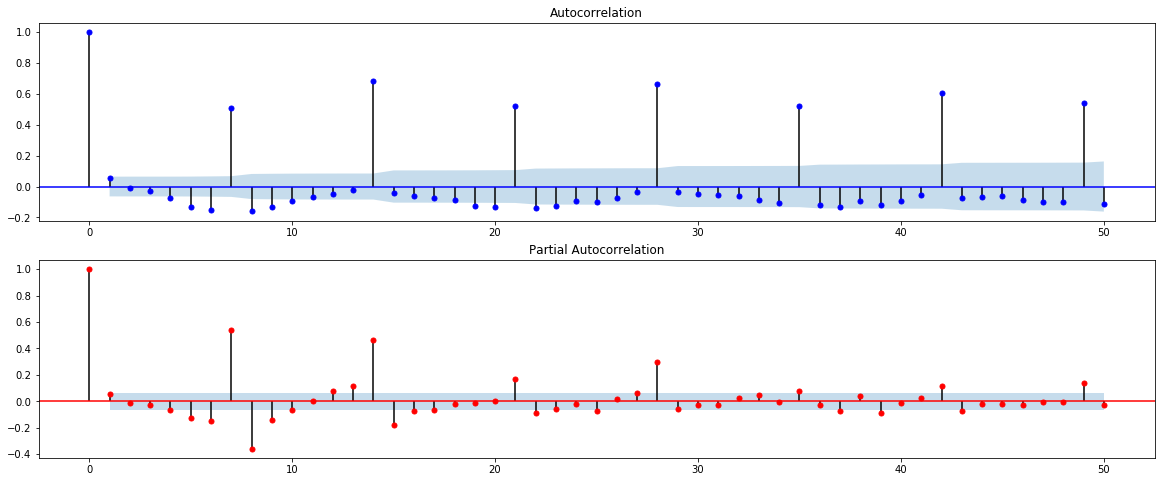

In [8]:
fig,ax = plt.subplots(2,figsize = (20,8))

plot_acf(sales_df.Sales, lags = 50, ax = ax[0], color = 'blue')
plot_pacf(sales_df.Sales, lags = 50, ax = ax[1], color = 'red')

From the ACF and PACF plots, it is evident that the data shows some seasonalities at certain lags - weekly trend with positive spikes at 7, 14, 21, 28....

In [12]:
# Applying Seasonal ARIMA

# Note: this block will run for 1.5hours minimum for the range specified.
# only (0,3) range used in the above line and using range above that would increase the time.

p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in (list(itertools.product(p,d,q)))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sales_df, order = param, 
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC : {}'.format(param, param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC : 19495.202593166083
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC : 18759.255191929682
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC : 18381.021132697715
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC : 17687.413420383622
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC : 17052.190499168395
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC : 16801.203991131006
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC : 18455.13813220235
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC : 17277.92403885829
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC : 17159.45490623205
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC : 17666.976672615863
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC : 17280.75931457444
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC : 17031.80456368564
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC : 17247.54266658415
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC : 17005.890839640033
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC : 16672.351708596216
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC : 17726.821484290944
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC : 17233.478488928435
ARIMA(0, 0, 0)x(1, 2

ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC : 17026.46156975976
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC : 16953.49860602511
ARIMA(0, 1, 2)x(1, 0, 2, 12)12 - AIC : 16726.737762641427
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC : 17335.812710376224
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC : 16783.928532751946
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC : 16873.71486199041
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC : 17643.476541989105
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC : 17755.3264808332
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC : 17484.367416197078
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC : 16804.996227753545
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC : 16781.707235367812
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC : 16711.655454651067
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC : 17071.45501218259
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC : 16612.84488718855
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC : 16550.57455368904
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC : 17231.47377375536
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC : 17567.713603838758
ARIMA(0, 1, 2)x(2, 2, 2

ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC : 16716.345560033442
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC : 16822.25375959457
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC : 16797.899427784883
ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC : 16784.860649112536
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC : 16873.871761788207
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC : 16700.9701740283
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC : 16797.423776405594
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC : 17374.150142646216
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC : 16752.996381873003
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC : 16580.248722946897
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC : 17222.82823421785
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC : 17005.702076058533
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC : 16790.402197498122
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC : 17524.724015117547
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC : 16943.306626739097
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC : 16723.312278311212
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC : 18179.649268058984
ARIMA(1, 0, 2)x(0,

ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC : 18443.640994554036
ARIMA(1, 2, 0)x(2, 2, 2, 12)12 - AIC : 18426.61863196118
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC : 17589.61032147464
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC : 17320.632545816487
ARIMA(1, 2, 1)x(0, 0, 2, 12)12 - AIC : 17097.116293671756
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC : 18139.840176997874
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC : 17522.863536127254
ARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC : 17276.688092985205
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC : 18999.295971163952
ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC : 18375.80510060458
ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC : 18046.678347224668
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC : 17344.89119316724
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC : 17313.27190876302
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC : 17094.266329951493
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC : 17690.381386190493
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC : 17096.718994983927
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC : 17277.886869075366
ARIMA(1, 2, 1)x(1, 

ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC : 18370.41272509614
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC : 17653.98931786044
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC : 17283.22174848369
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC : 17233.525009619036
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC : 17189.960041591658
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC : 16981.899596286516
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC : 17494.35808794293
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC : 17057.192936771928
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC : 16978.10985279308
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC : 17926.307116036107
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC : 17595.837323347092
ARIMA(2, 1, 0)x(1, 2, 2, 12)12 - AIC : 17283.652030448768
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC : 16994.255977068126
ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC : 16958.095804553504
ARIMA(2, 1, 0)x(2, 0, 2, 12)12 - AIC : 16939.437159657282
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC : 17178.151143244766
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC : 16960.66115850326
ARIMA(2, 1, 0)x(2, 1

ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC : 17095.69330348698
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC : 17961.358858260082
ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC : 17807.431004535232
ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC : 17557.63319306522
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC : 17046.052827144376
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC : 17048.111547747376
ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC : 17030.510168390203
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC : 17237.158877653736
ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC : 17116.845503977525
ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC : 17090.98488759675
ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC : 17673.832418958336
ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC : 17579.791366284062
ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC : 17564.983583393892


The lowest value of AIC is for : (0,1,1)x(0,2,2,12)

The AIC value is :  16117.725424857992

The Model summary stats are : 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.053      0.957      0.339      -0.054       0.156
ar.L2         -0.1197      0.040     -3.020      0.003      -0.197      -0.042
ar.L3         -0.1001      0.038     -2.653      0.008      -0.174      -0.026
ar.L4         -0.2092      0.030     -6.897      0.000      -0.269      -0.150
ar.L5         -0.2718      0.037     -7.247      0.000      -0.345      -0.198
ar.L6         -0.3545      0.037     -9.555      0.000      -0.427      -0.282
ar.L7          0.4130      0.036     11.320      0.000       0.341       0.484
ar.L8         -0.4008      0.030    -13.496      0.000      -0.459      -0.343
ar.L9         -0.1786      0.038     -4.743      0.000      -0.252      -0.105
ar.L10        -0.2491      0.039     -6.341      0.000      

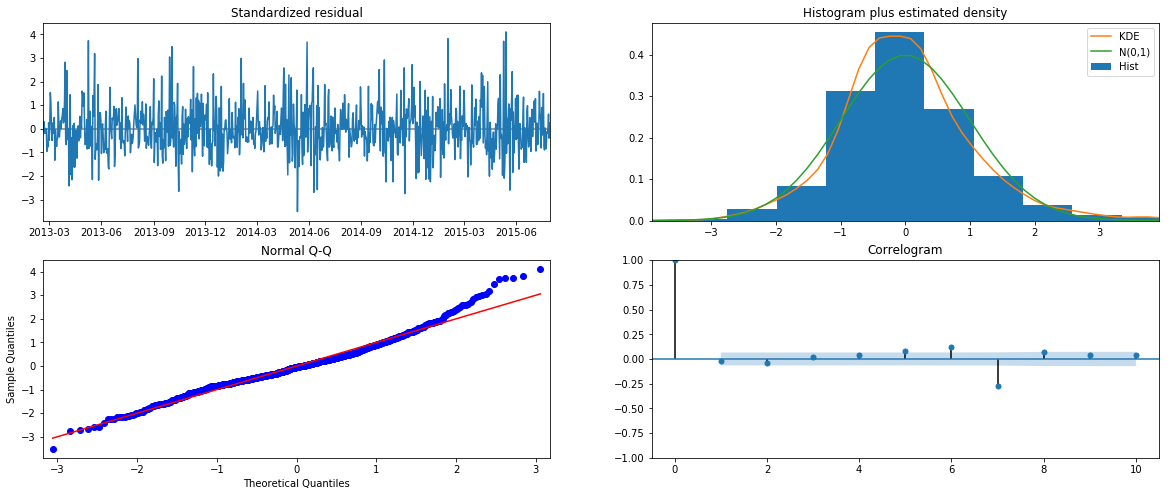

In [37]:
# Fitting a model

# Here, (11,1,1) x (2,1,0,12) orders are used instead of (0,1,1)x(0,2,2,12) values as it yielded better results
model = sm.tsa.statespace.SARIMAX(sales_df, order = (11,1,1), seasonal_order = (2,1,0,12),
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
results = model.fit()

print("The AIC value is : " , results.aic)
print("\nThe Model summary stats are : \n", results.summary().tables[1])

print("\nThe Model diagnostics are observed to investiage any unusual behavior : \n ")
results.plot_diagnostics(figsize =  (20,8))
plt.show()

The results are not perfect but the model residues are slightly normally distributed. The Q-Q plots shows normality.

Validating the Store Sales forecasted 


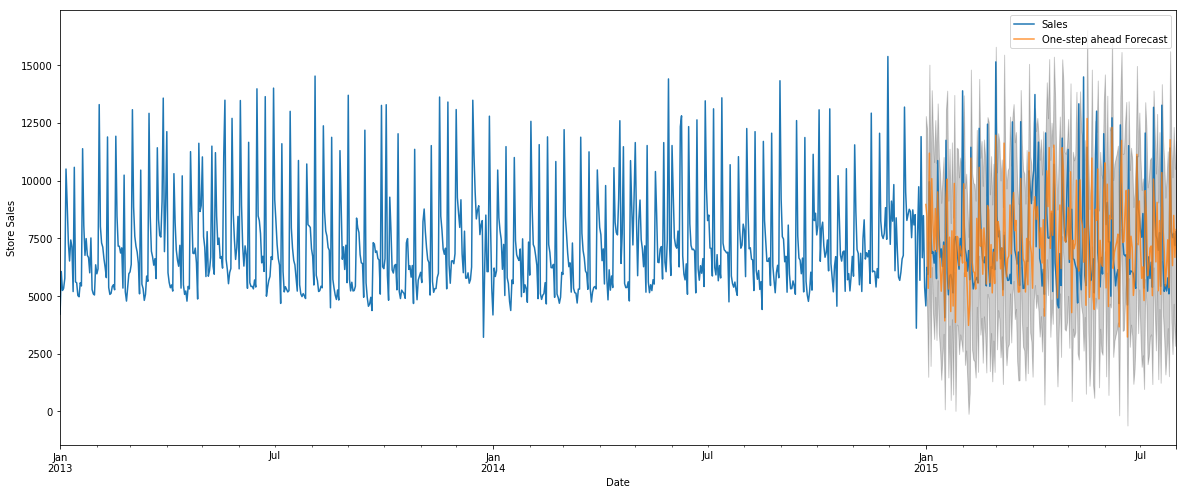

The Mean Squared Error is: 4169545.69
The Root Mean Squared Error is: 2041.95


In [33]:
# Validating forecasts:

print("Validating the Store Sales forecasted ")

pred = results.get_prediction(start = pd.to_datetime('2015-01-01')) 
pred_ci = pred.conf_int()

ax = sales_df['2013':].plot(label = 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.8, figsize = (20,8))

ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color = 'k', alpha = 0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Store Sales')

plt.legend()
plt.show()

y_forecasted = pred.predicted_mean
y_truth = sales_df['2015-01-01':].Sales

mse = ((y_forecasted - y_truth) ** 2).mean()

print('The Mean Squared Error is: {}'.format(round(mse,2)))

print('The Root Mean Squared Error is: {}'.format(round(np.sqrt(mse),2)))

Producing and Visualizing the Store Sales 


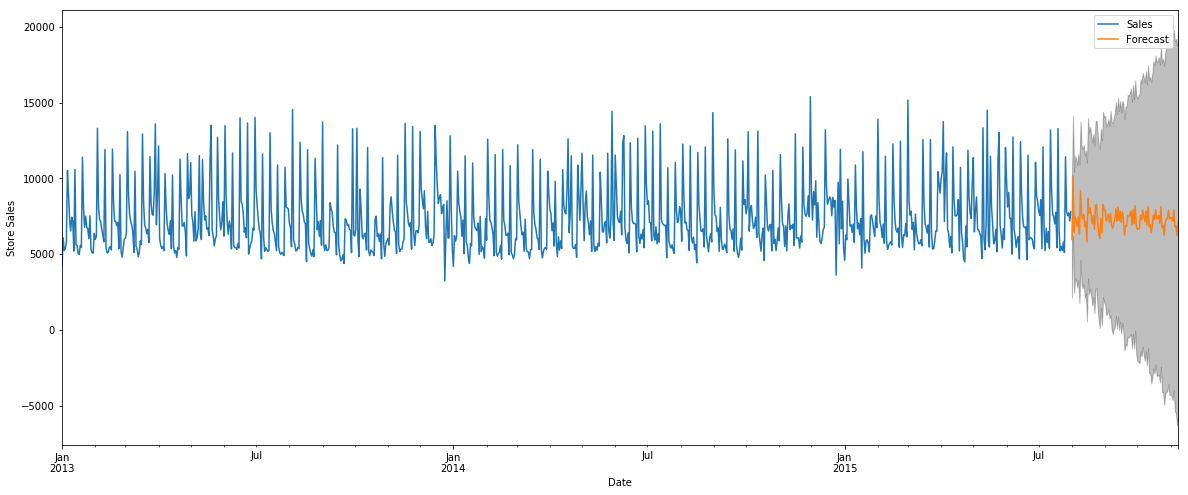

In [34]:
# Producing and visualizing forecasts 

print("Producing and Visualizing the Store Sales ")

pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

ax = sales_df.plot(label = 'observed', figsize = (20,8))

pred_uc.predicted_mean.plot(ax = ax, label = 'Forecast')

ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color = 'k', alpha = 0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Store Sales')

plt.legend()

plt.show()

This model's performance has a scope for improvement.